# Set up 

In [1]:
import tellurium as te
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import aesara.tensor as at
import aesara
floatX = aesara.config.floatX
import pymc as pm
import numpy as np

import cobra
import os

from scipy import stats
import scipy as sp

print(os.getcwd())

WARNING (aesara.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (aesara.configdefaults): g++ not detected!  Aesara will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set Aesara flags cxx to an empty string.
WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


c:\Users\user\Documents\research\BMCA-pipeline\notebooks\all_data


In [2]:
os.chdir('../..')
from src import BMCA, util
import emll
from emll.aesara_utils import LeastSquaresSolve
os.chdir('notebooks/all_data/')

# Perturbing enzymes

In [3]:
Teusink_ant ='../../data/interim/Antimony/Simplified_Teusink_reg1.ant' 

data_file05 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_0.5.csv'
data_file10 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_1.01.csv'
data_file15 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_1.5.csv'
data_file3 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_3.csv'
data_file5 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_5.csv'
data_file7 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_7.csv'
data_file100 = '../../data/interim/generated_data/simplTeusink-reg1/Simplified_Teusink_reg1_10.csv'

r = te.loada(Teusink_ant)
r.conservedMoietyAnalysis = True
r.steadyState()

# data_files = [data_file05, data_file10, data_file15, data_file3, data_file5, data_file7, data_file100]

9.995861419348e-16

In [4]:
BMCA_obj05 = BMCA.BMCA(Teusink_ant, data_file05)
BMCA_obj10 = BMCA.BMCA(Teusink_ant, data_file10)
BMCA_obj15 = BMCA.BMCA(Teusink_ant, data_file15)
BMCA_obj3 = BMCA.BMCA(Teusink_ant, data_file3)
BMCA_obj5 = BMCA.BMCA(Teusink_ant, data_file5)
BMCA_obj7 = BMCA.BMCA(Teusink_ant, data_file7)
BMCA_obj100 = BMCA.BMCA(Teusink_ant, data_file100)


Model does not contain SBML fbc package information.


../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant
Set parameter Username
Academic license - for non-commercial use only - expires 2024-10-23


Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGAPDH>'
Missing upper flux bound set to '1

../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


Model does not contain SBML fbc package information.
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPGI>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPGI>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vGLYCO>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vGLYCO>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vTreha>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vTreha>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vPFK>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vPFK>'
Missing lower flux bound set to '-1000.0' for reaction: '<Reaction vALD>'
Missing upper flux bound set to '1000.0' for reaction: '<Reaction vALD>'
Missing lower flux bound set to '-1000.0' for reaction: '

../../data/interim/Antimony/Simplified_Teusink_reg1_cobra.ant


In [5]:
def run_ADVI(BMCA_obj):
    with pm.Model() as pymc_model:
        
        # Initialize elasticities
        Ex_t = pm.Deterministic('Ex', util.initialize_elasticity(BMCA_obj.Ex.to_numpy(), name='Ex'))
        Ey_t = pm.Deterministic('Ey', util.initialize_elasticity(BMCA_obj.Ey.to_numpy(), name='Ey'))
        e_obs = pm.Normal('e_obs', mu=1, sigma=1, observed=BMCA_obj.en.T)
        chi_obs = pm.Normal('chi_obs', mu=0, sigma=10, observed=BMCA_obj.xn.T)
        y_obs = pm.Normal('y_obs', mu=0, sigma=10, observed=BMCA_obj.yn.T)
        likelihood = pm.Deterministic('vn', e_obs * (np.ones(BMCA_obj.en.T.shape) + pm.math.dot(Ex_t,chi_obs) + pm.math.dot(Ey_t,y_obs)))
        v_hat_obs = pm.Normal('v_hat_obs', mu=likelihood, sigma=0.1, observed=BMCA_obj.vn.squeeze().T)
    
        N_ITERATIONS = 45000
    
    with pymc_model:
        advi = pm.ADVI()
        tracker = pm.callbacks.Tracker(
            mean = advi.approx.mean.eval,
            std = advi.approx.std.eval
        )
        approx = advi.fit(
            n=       N_ITERATIONS, 
            callbacks = [tracker],
            obj_optimizer=pm.adagrad_window(learning_rate=5E-3), 
            total_grad_norm_constraint=0.7,
            obj_n_mc=1)
    
    with sns.plotting_context('notebook', font_scale=1.2):

        fig = plt.figure(figsize=(5,4))
        plt.plot(approx.hist + 30, '.', rasterized=True, ms=1)
        # plt.ylim([-1E1, 1E3])
        plt.xlim([0, N_ITERATIONS])
        sns.despine(trim=True, offset=10)

        plt.ylabel('-ELBO')
        plt.xlabel('Iteration')
        plt.title('in vitro ADVI convergence')
        plt.tight_layout()

    return approx.sample(draws=1000, random_seed=1)


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,124.9


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,030.8


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,083.4


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,221.6


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 1,596.2


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 2,365.3


c:\Users\user\miniconda3\envs\new_Gayles\lib\site-packages\aesara\scalar\basic.py:2925: RuntimeWarning:

invalid value encountered in log

Finished [100%]: Average Loss = 4,465.3


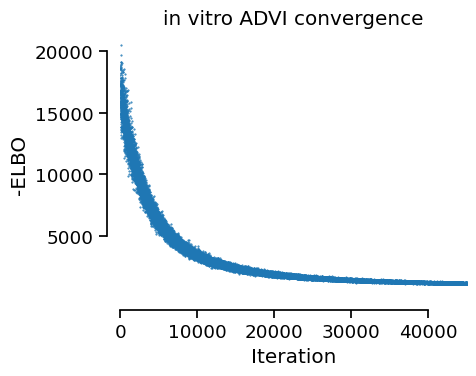

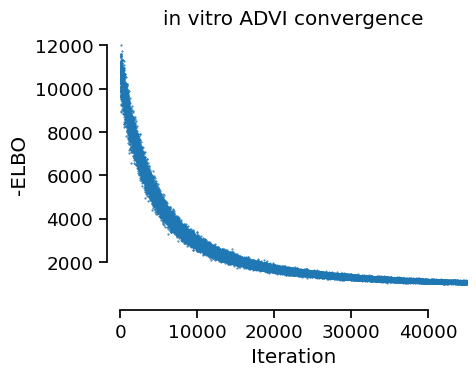

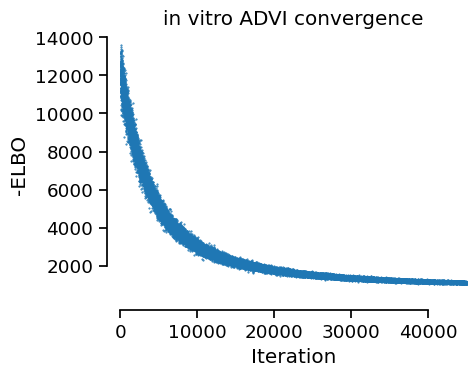

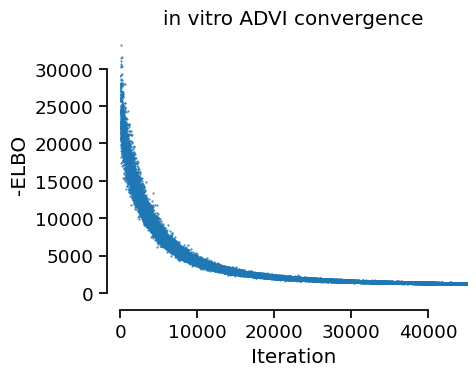

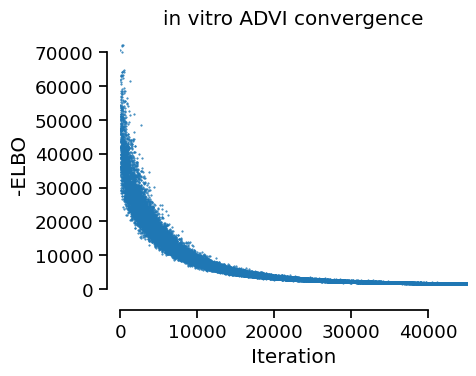

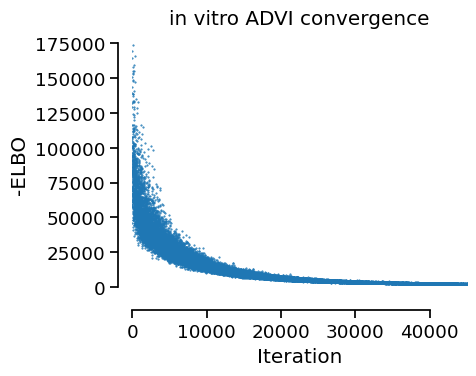

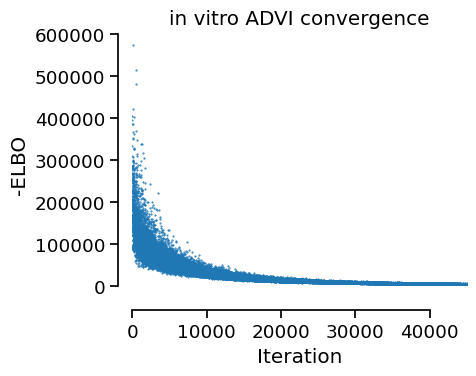

In [6]:
trace05 = run_ADVI(BMCA_obj05)
trace10 = run_ADVI(BMCA_obj10)
trace15 = run_ADVI(BMCA_obj15)
trace3 = run_ADVI(BMCA_obj3)
trace5 = run_ADVI(BMCA_obj5)
trace7 = run_ADVI(BMCA_obj7)
trace100 = run_ADVI(BMCA_obj100)

In [7]:
# Ey_advi = (trace['posterior']['Ey']).to_numpy().squeeze()
ExTrace_05 = (trace05['posterior']['Ex']).to_numpy().squeeze()
ExTrace_10 = (trace10['posterior']['Ex']).to_numpy().squeeze()
ExTrace_15 = (trace15['posterior']['Ex']).to_numpy().squeeze()
ExTrace_3 = (trace3['posterior']['Ex']).to_numpy().squeeze()
ExTrace_5 = (trace5['posterior']['Ex']).to_numpy().squeeze()
ExTrace_7 = (trace7['posterior']['Ex']).to_numpy().squeeze()
ExTrace_100 = (trace100['posterior']['Ex']).to_numpy().squeeze()

In [8]:
medEx_05 = np.median(ExTrace_05, axis=0)
medEx_10 = np.median(ExTrace_10, axis=0)
medEx_15 = np.median(ExTrace_15, axis=0)
medEx_3 = np.median(ExTrace_3, axis=0)
medEx_5 = np.median(ExTrace_5, axis=0)
medEx_7 = np.median(ExTrace_7, axis=0)
medEx_100 = np.median(ExTrace_100, axis=0)

In [9]:
# first regulator, PYR on PFK
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['vPFK']]
for i in [medEx_05, medEx_10, medEx_15, medEx_3, medEx_5, medEx_7, medEx_100]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['vPFK']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x'], axis='columns') 

,gt,0.5x,1.01x,1.5x,3x,5x,7x,10x
G6P,0.000000,0.003176,0.005205,0.003364,-0.002645,-0.000139,-0.002912,-0.006831
TRIO,0.000000,0.013381,-0.006874,0.001493,0.000236,-0.007323,-0.007887,-0.003741
ACE,0.000000,-0.000086,0.011132,0.003764,-0.018695,-0.015047,-0.031974,-0.030949
P3G,0.000000,-0.000089,0.000664,-0.001153,-0.008512,-0.008168,-0.012154,-0.016676
PEP,0.000000,-0.003890,-0.001056,0.009719,-0.020420,-0.021476,-0.023657,-0.028163
GLCi,0.000000,-0.004047,0.003891,0.010222,0.001521,0.000975,-0.002593,0.011966
F6P,1.013324,0.364033,1.184756,0.721269,0.837487,0.820708,0.796172,0.747552
BPG,0.000000,0.007758,0.000766,-0.007045,-0.010095,-0.001798,-0.008545,-0.012591
PYR,-0.680728,-0.006362,0.000468,-0.001751,-0.043350,-0.097587,-0.134646,-0.155747
F16P,-0.213181,0.000701,-0.796428,-0.302150,-0.313536,-0.293262,-0.265410,-0.239400


In [10]:
# second regulator, P3G on PGI
a = [pd.DataFrame(r.getScaledElasticityMatrix(), columns=r.getFloatingSpeciesIds(), index=r.getReactionIds()).loc['vPGI']]
for i in [medEx_05, medEx_10, medEx_15, medEx_3, medEx_5, medEx_7, medEx_100]:
    aa = pd.DataFrame(i, index=r.getReactionIds(), columns=r.getFloatingSpeciesIds()).loc['vPGI']
    a.append(aa)
a = pd.concat(a, axis=1)
a.set_axis(['gt', '0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x'], axis='columns') 

,gt,0.5x,1.01x,1.5x,3x,5x,7x,10x
G6P,1.850016,1.575811,0.708771,1.399683,1.808030,1.842273,1.835570,1.850390
TRIO,0.000000,0.001233,0.000227,0.004648,0.003498,-0.004466,0.001852,-0.006693
ACE,0.000000,0.002007,-0.004570,-0.007727,-0.005573,-0.009269,0.009002,-0.003530
P3G,0.000000,0.002755,0.003927,0.004464,-0.005338,0.002761,-0.006422,0.000310
PEP,0.000000,0.000491,0.002069,0.002034,0.000137,0.002644,-0.000223,0.002514
GLCi,0.000000,0.003060,-0.001478,-0.003179,0.001681,-0.000143,0.006668,0.009334
F6P,-1.472593,-1.238271,-0.753889,-1.177581,-1.447652,-1.432990,-1.441672,-1.422947
BPG,0.000000,0.005458,0.010234,0.002277,-0.009203,-0.002274,-0.004822,0.000042
PYR,0.000000,0.005593,-0.013640,-0.008538,-0.003101,-0.001966,0.000998,-0.003410
F16P,0.000000,0.004579,-0.002708,0.004035,-0.005994,0.002524,0.000557,-0.000828


## Calculating FCCs

In [11]:
gtFCC = pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), index=r.getReactionIds(), columns=r.getReactionIds())

In [12]:
def estimate_CCs(BMCA_obj, Ex):
    BMCA_obj.vn[BMCA_obj.vn == 0] = 1e-6
    
    a = np.diag(BMCA_obj.en.values / BMCA_obj.vn.values)
    a = np.diag(a)
    a = a[np.newaxis,:].repeat(1000, axis=0)

    Ex_ss = a @ Ex
    As = BMCA_obj.N @ np.diag(BMCA_obj.v_star) @ Ex_ss
    bs = BMCA_obj.N @ np.diag(BMCA_obj.v_star)
    bs = bs[np.newaxis, :].repeat(1000, axis=0)
    
    As = at.as_tensor_variable(As)
    bs = at.as_tensor_variable(bs)

    def solve_aesara(A, b):
        rsolve_op = LeastSquaresSolve()
        return rsolve_op(A, b).squeeze()

    CCC, _ = aesara.scan(lambda A, b: solve_aesara(A, b),
                        sequences=[As, bs], strict=True)

    identity = np.eye(len(BMCA_obj.N.T))
    identity = identity[np.newaxis,:].repeat(1000, axis=0)
    
    FCC = (Ex_ss @ CCC.eval()) + identity
    
    # return CCC.eval(), FCC
    return FCC


### Negative predictions

In [13]:
postFCC05 = estimate_CCs(BMCA_obj05, ExTrace_05)
postFCC10 = estimate_CCs(BMCA_obj10, ExTrace_10)
postFCC15 = estimate_CCs(BMCA_obj15, ExTrace_15)
postFCC3 = estimate_CCs(BMCA_obj3, ExTrace_3)
postFCC5 = estimate_CCs(BMCA_obj5, ExTrace_5)
postFCC7 = estimate_CCs(BMCA_obj7, ExTrace_7)
postFCC100 = estimate_CCs(BMCA_obj100, ExTrace_100)

In [14]:
rxn_FCCs = [postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]
pt_labels = ['0.5x', '1.01x', '1.5x', '3x', '5x', '7x', '10x']

In [15]:
def append_FCC_df(postFCC, label):
    dfs=[]
    
    for idx, rxn in enumerate(r.getReactionIds()):
        # negativity applied here
        df = -pd.DataFrame(postFCC[:,idx,:], columns=r.getReactionIds())
        df['pt_rxn']=[rxn]*len(df)
        dfs.append(df)
    
    w = pd.concat(dfs)
    w['pt_str']=[label]*len(w)
    return w

prd_FCCs = pd.concat([append_FCC_df(rxn_FCCs[i], pt_labels[i]) for i in range(len(rxn_FCCs))])

In [16]:
medPrdFCCs = pd.pivot_table(prd_FCCs, index=['pt_rxn','pt_str'], aggfunc='median', sort=False)
# medPrdFCCs.loc['vGLK']
medPrdFCCs.head()

,,vGLK,vPGI,vGLYCO,vTreha,vPFK,vALD,vGAPDH,vPGK,vPGM,vENO,vPYK,vPDC,vSUC,vGLT,vADH,vG3PDH
pt_rxn,pt_str,,,,,,,,,,,,,,,,
vGLK,0.5x,-1.823451,0.025537,0.016474,0.168397,0.119750,-0.004329,-0.001856,-0.004189,-0.007216,-0.003973,-0.005187,-0.002567,-0.001076,0.512055,-0.002741,-0.004391
vPGI,0.5x,0.084528,-1.830090,-0.021009,-0.214763,0.714288,-0.002201,-0.006195,-0.010811,-0.007727,-0.004984,-0.002235,0.003249,-0.000340,0.271354,-0.000866,-0.004429
vGLYCO,0.5x,0.217728,-0.058287,-1.052923,-0.540990,-0.247457,-0.001082,0.000224,-0.000268,0.001417,0.001380,-0.000353,-0.005543,-0.001690,0.664010,-0.004307,-0.002493
vTreha,0.5x,0.219717,-0.047649,-0.051195,-1.523323,-0.211172,-0.007811,0.002996,0.000251,-0.006111,-0.004076,-0.003953,-0.005864,-0.002031,0.642792,-0.005177,-0.005520
vPFK,0.5x,0.084528,0.169910,-0.021009,-0.214763,-1.285712,-0.002201,-0.006195,-0.010811,-0.007727,-0.004984,-0.002235,0.003249,-0.000340,0.271354,-0.000866,-0.004429


### Graphing the averaged differences between ground truth and predicted distributions

C:\Users\user\AppData\Local\Temp\ipykernel_15960\3859003407.py:12: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.



<Figure size 1600x1000 with 0 Axes>

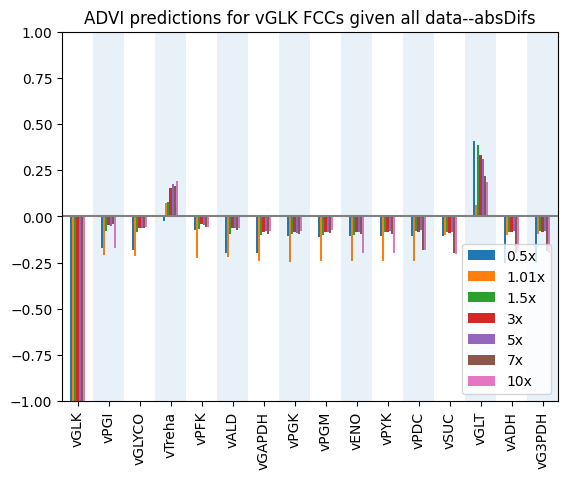

<Figure size 1600x1000 with 0 Axes>

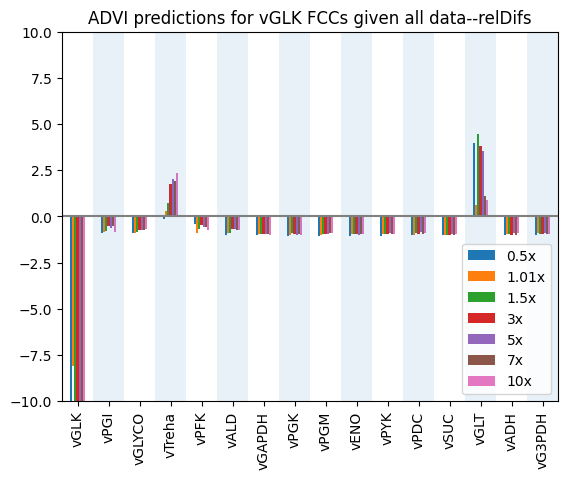

<Figure size 1600x1000 with 0 Axes>

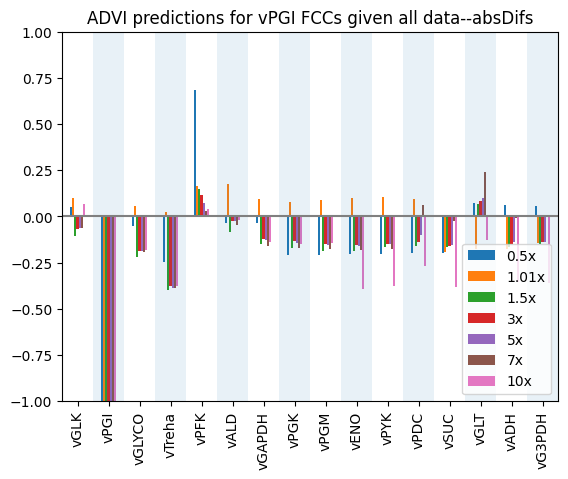

<Figure size 1600x1000 with 0 Axes>

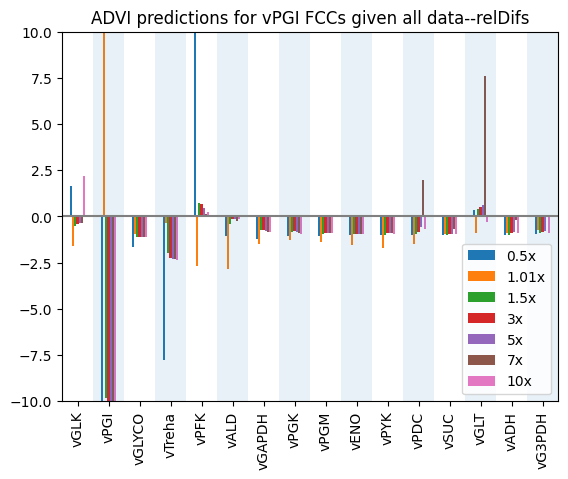

<Figure size 1600x1000 with 0 Axes>

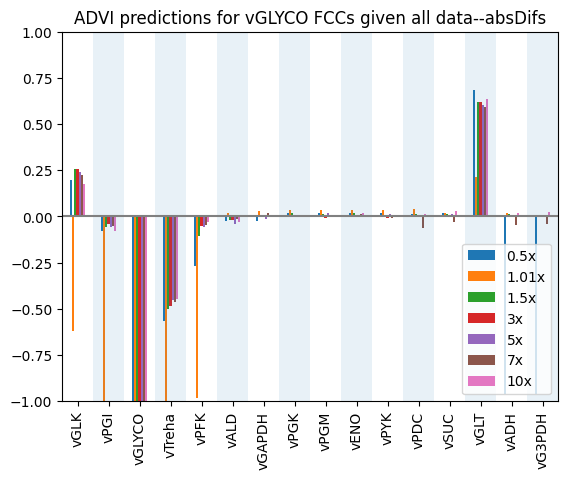

<Figure size 1600x1000 with 0 Axes>

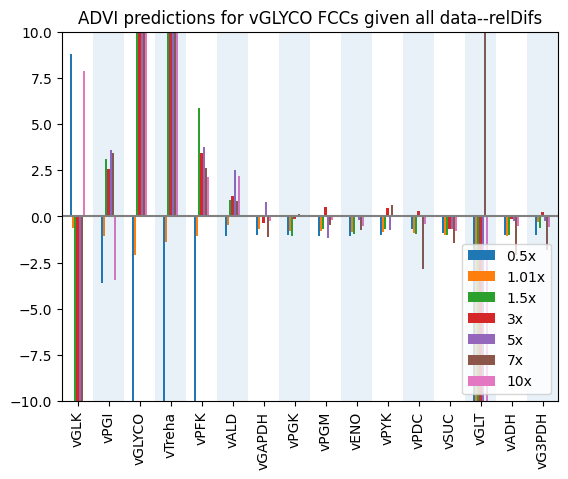

<Figure size 1600x1000 with 0 Axes>

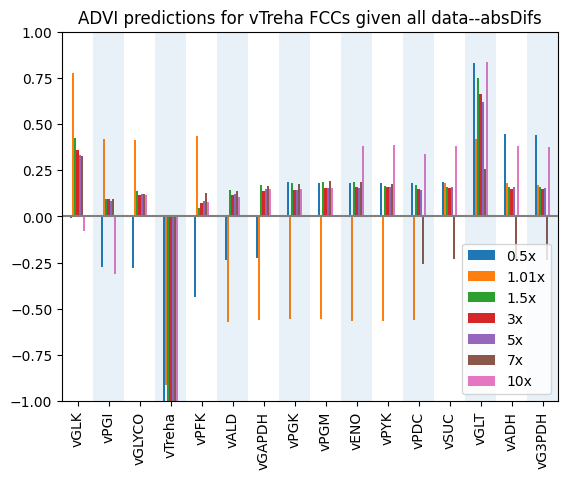

<Figure size 1600x1000 with 0 Axes>

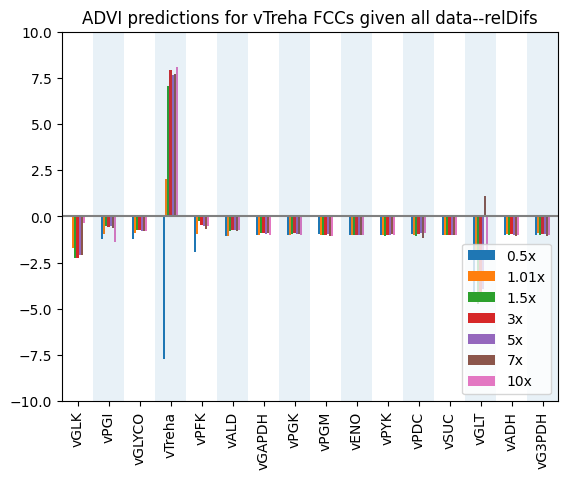

<Figure size 1600x1000 with 0 Axes>

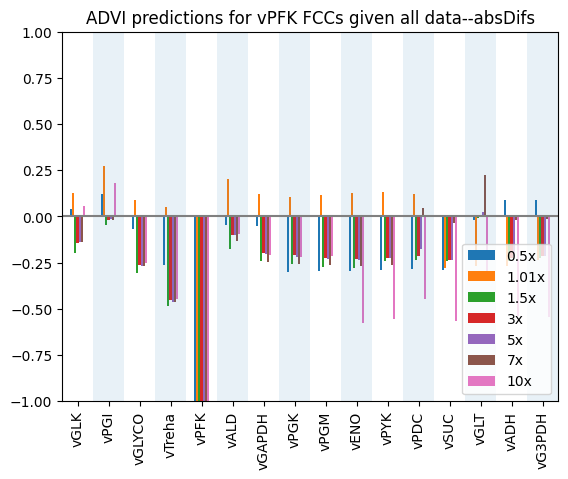

<Figure size 1600x1000 with 0 Axes>

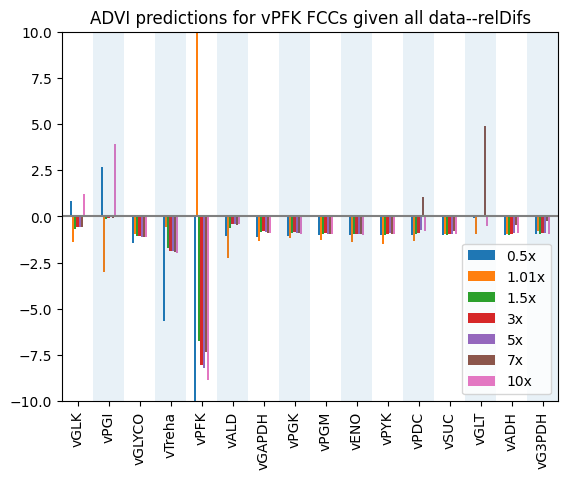

<Figure size 1600x1000 with 0 Axes>

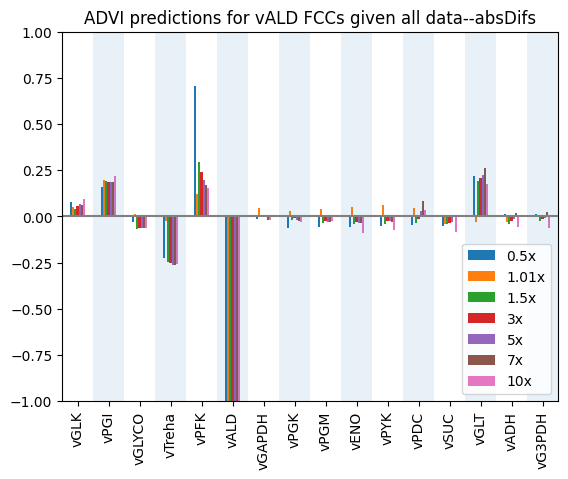

<Figure size 1600x1000 with 0 Axes>

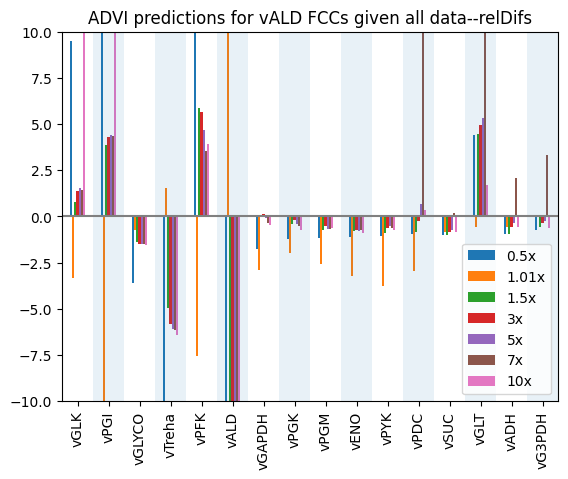

<Figure size 1600x1000 with 0 Axes>

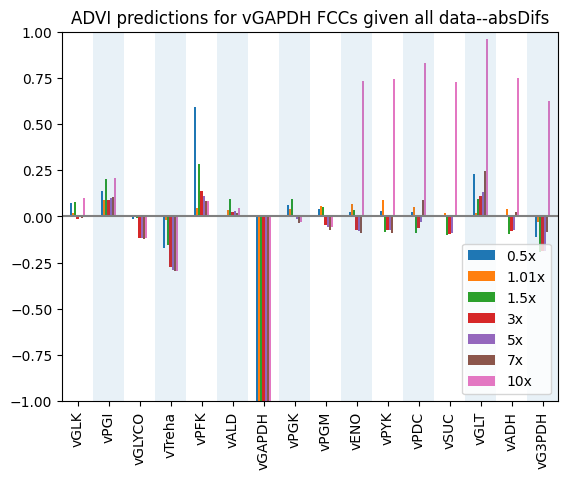

<Figure size 1600x1000 with 0 Axes>

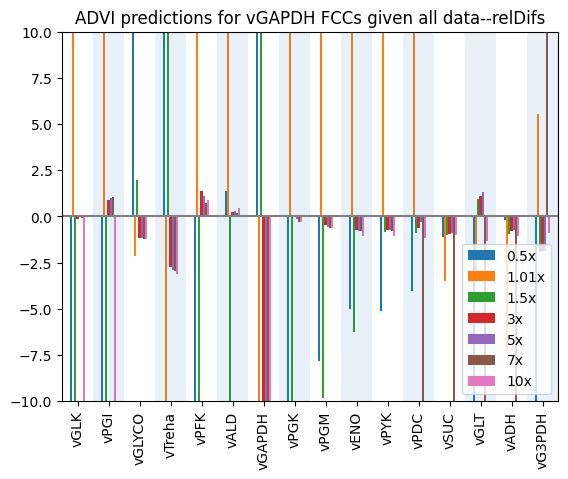

<Figure size 1600x1000 with 0 Axes>

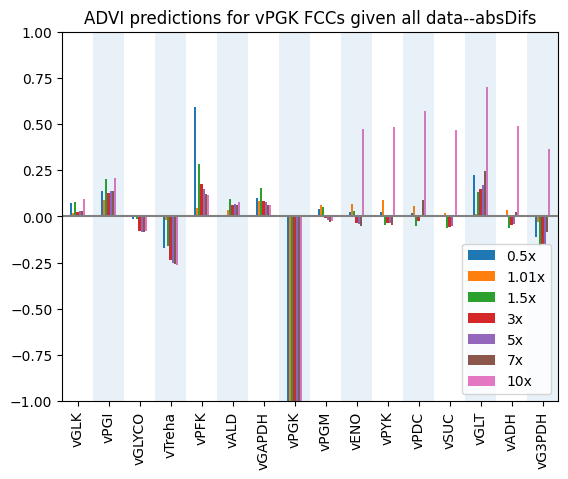

<Figure size 1600x1000 with 0 Axes>

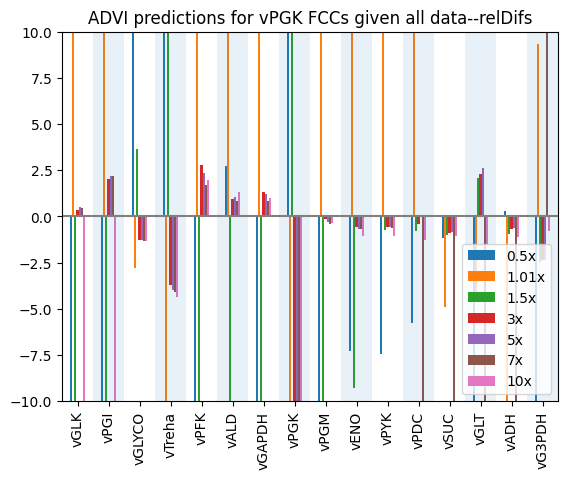

<Figure size 1600x1000 with 0 Axes>

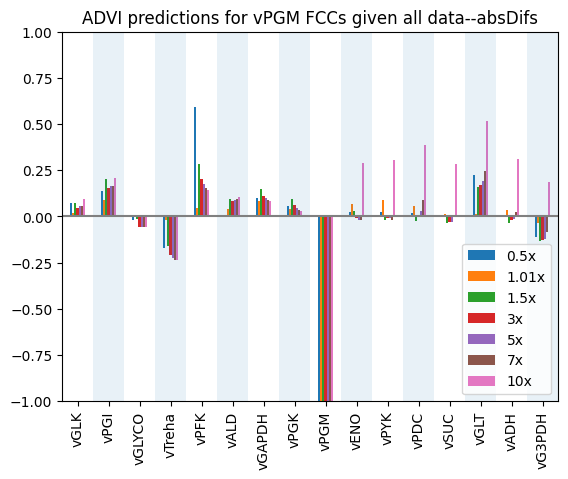

<Figure size 1600x1000 with 0 Axes>

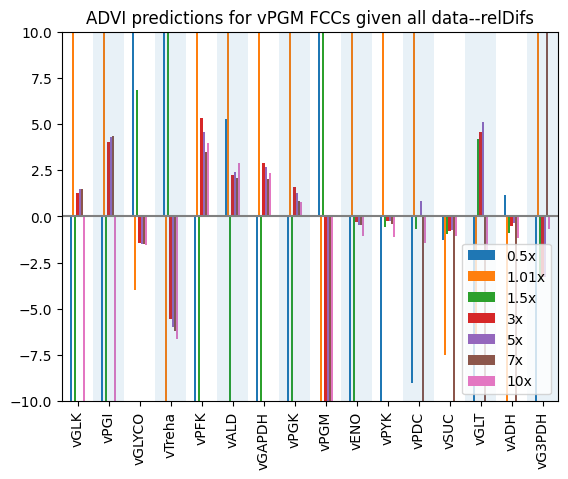

<Figure size 1600x1000 with 0 Axes>

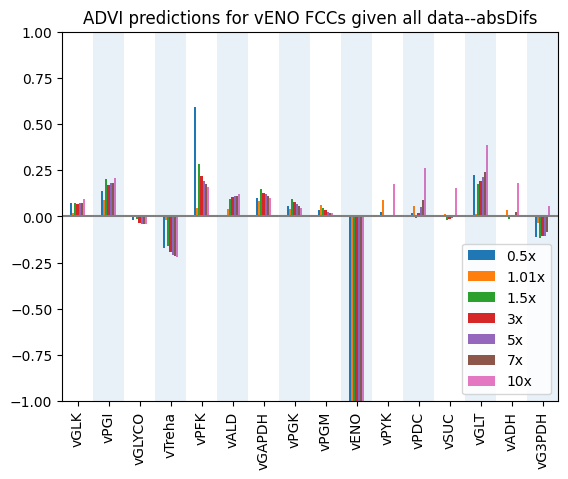

<Figure size 1600x1000 with 0 Axes>

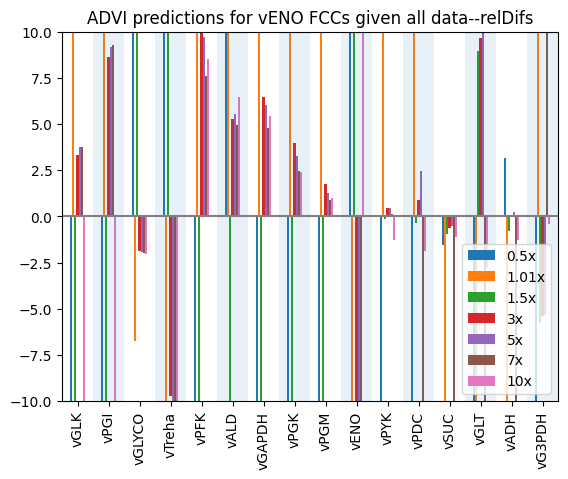

<Figure size 1600x1000 with 0 Axes>

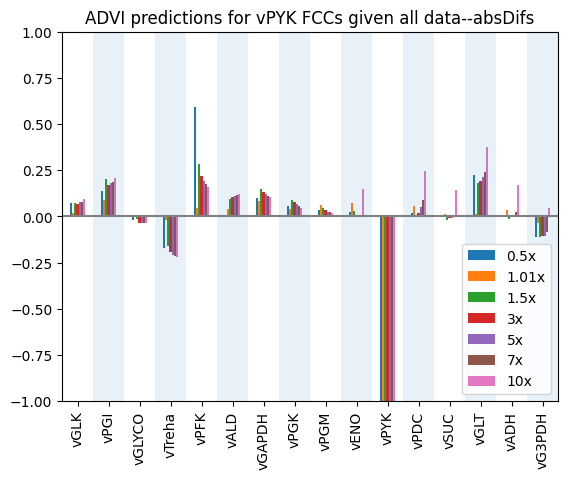

<Figure size 1600x1000 with 0 Axes>

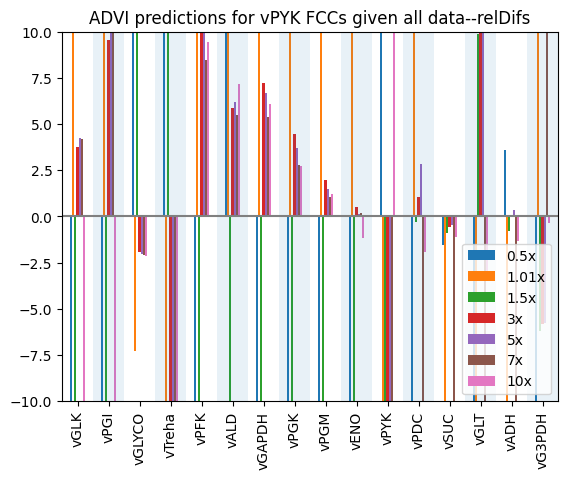

<Figure size 1600x1000 with 0 Axes>

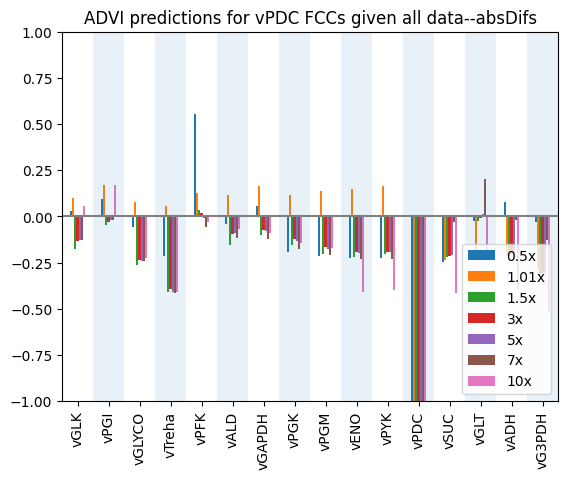

<Figure size 1600x1000 with 0 Axes>

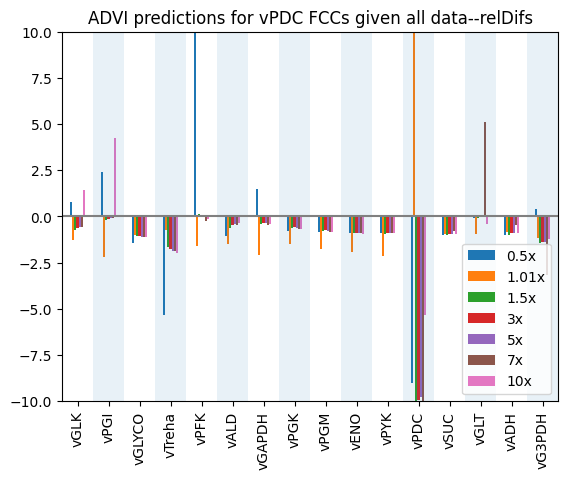

<Figure size 1600x1000 with 0 Axes>

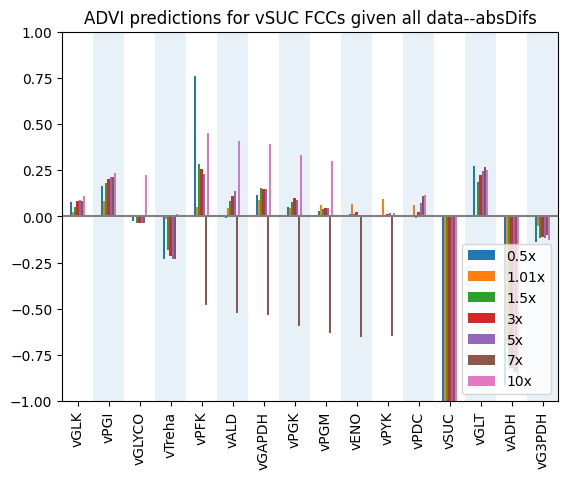

<Figure size 1600x1000 with 0 Axes>

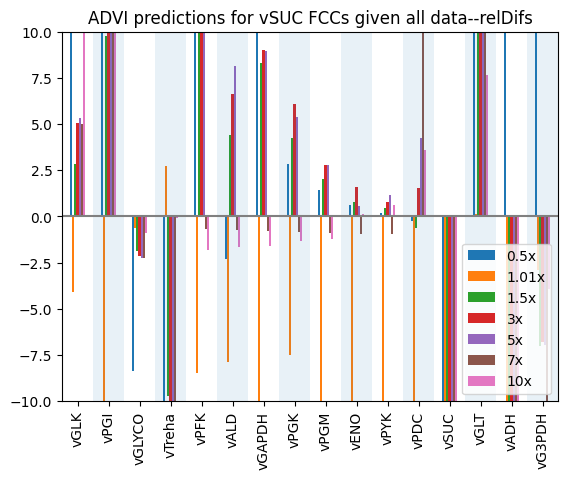

<Figure size 1600x1000 with 0 Axes>

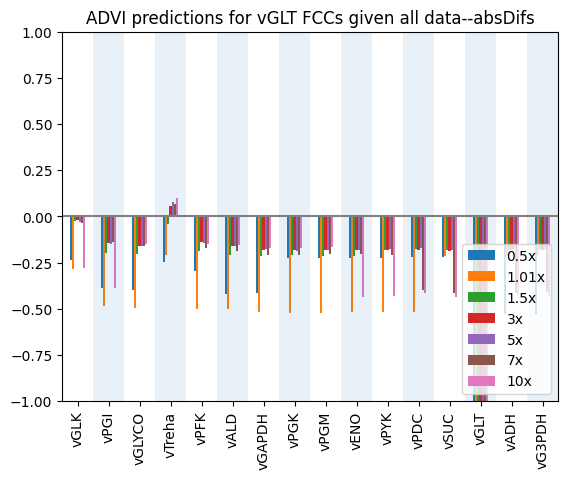

<Figure size 1600x1000 with 0 Axes>

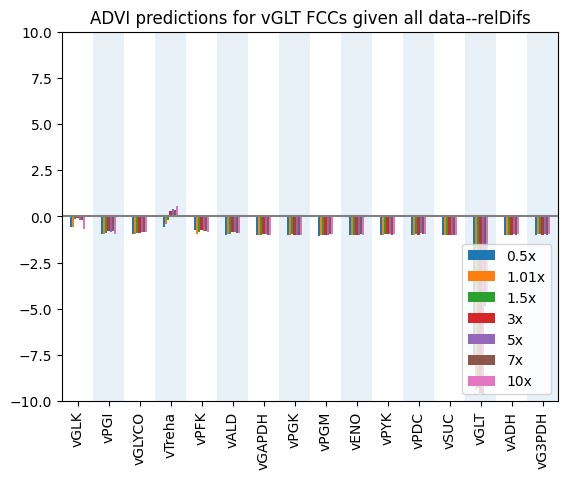

<Figure size 1600x1000 with 0 Axes>

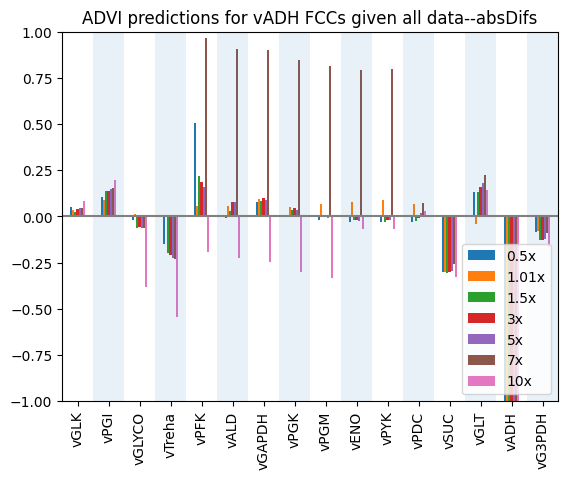

<Figure size 1600x1000 with 0 Axes>

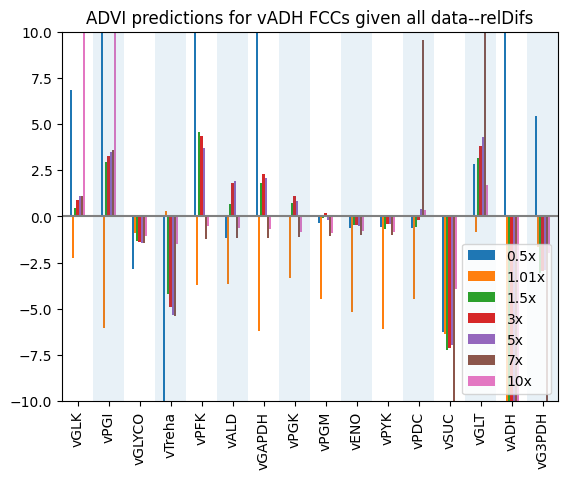

<Figure size 1600x1000 with 0 Axes>

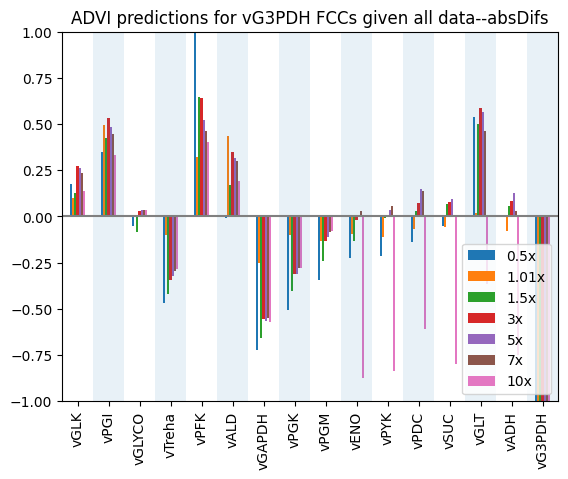

<Figure size 1600x1000 with 0 Axes>

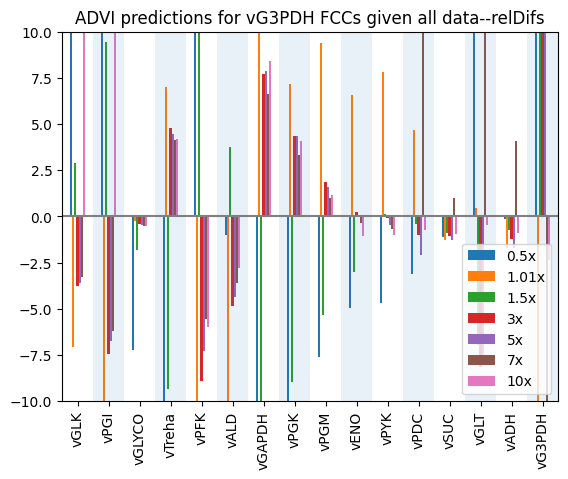

In [17]:
# for each reaction that can be perturbed
for rxn in r.getReactionIds():
    # locate the applicable rows in the medPrdFCCs df
    a = medPrdFCCs.loc[rxn]
    gtvals = np.repeat(gtFCC[rxn].values, repeats=len(pt_labels), axis=0).reshape((len(pt_labels), -1))
    # calculate the absolute difference...
    absDifs = a - gtvals
    # and the relative difference
    relDifs = absDifs/gtvals
    
    # plot both graphs 
    f1 = plt.figure(figsize=(16, 10))
    absDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-1,1))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--absDifs')

    f2 = plt.figure(figsize=(16, 10))
    relDifs.T.plot(kind='bar')
    # alternate color each group of reactions so it is easier to see
    for i in range(8):
            plt.axvspan(2*i + 0.5, 2*i + 1.5, alpha=0.1)
    plt.axhline(0, c='gray')
    plt.ylim((-10,10))
    plt.legend(loc='lower right')
    plt.title(f'ADVI predictions for {rxn} FCCs given all data--relDifs')

In [18]:
plt.close("all")

## Evaluating FCC ranking

In [19]:
gtFCC=pd.DataFrame(r.getScaledFluxControlCoefficientMatrix(), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
gtFCC = pd.DataFrame(np.select([m1], [float('Nan')], gtFCC), columns=gtFCC.columns, index=gtFCC.index)
gtFCC_rankings= gtFCC.rank(axis=1, ascending=False, na_option='keep')
# gtFCC_rankings

In [20]:
m1 = gtFCC_rankings.isin([1.0])  
m2 = gtFCC_rankings.isin([2.0])  
m3 = gtFCC_rankings.isin([3.0])  
a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

trueRanks = pd.concat([a,b,c], axis=1)
trueRanks['topThree'] = trueRanks[0] + trueRanks[1] + trueRanks[2]

In [21]:
rxn_FCCs = [postFCC05, postFCC10, postFCC15, postFCC3, postFCC5, postFCC7, postFCC100]
scores = []
for pt_level in rxn_FCCs:
    postFCC_med=pd.DataFrame(np.median(pt_level, axis=0), columns=r.getReactionIds(), index=r.getReactionIds()).abs()
    # m1 = gtFCC.index.values[:, None] == gtFCC.columns.values
    postFCC_med = pd.DataFrame(np.select([m1], [float('Nan')], postFCC_med), columns=gtFCC.columns, index=gtFCC.index)
    postFCC_med_rankings= postFCC_med.rank(axis=1, ascending=False, na_option='keep')
  
    m1 = postFCC_med_rankings.isin([1.0])  
    m2 = postFCC_med_rankings.isin([2.0])  
    m3 = postFCC_med_rankings.isin([3.0])  
    a = m1.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    b = m2.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)
    c = m3.mul(r.getReactionIds()).apply(lambda x: [i for i in x if i], axis=1)

    prdRanks = pd.concat([a,b,c], axis=1)
    prdRanks['topThree'] = prdRanks[0] + prdRanks[1] + prdRanks[2]

    scores.append([len([i for i in prdRanks['topThree'][rxn] if i in trueRanks['topThree'][rxn]]) for rxn in r.getReactionIds()])

topThreeCheckdf = pd.DataFrame(scores, columns=r.getReactionIds(), index=pt_labels).T

In [22]:
topThreeCheckdf.style.background_gradient(cmap='RdYlBu', axis=None)
# sns.heatmap(topThreeCheckdf, annot=True, cmap='RdYlBu')

,0.5x,1.01x,1.5x,3x,5x,7x,10x
vGLK,2,2,2,3,2,2,1
vPGI,1,1,2,2,1,2,1
vGLYCO,1,3,2,3,2,3,2
vTreha,2,2,2,3,2,2,1
vPFK,1,1,1,2,1,2,1
vALD,1,1,2,2,1,2,0
vGAPDH,1,0,2,2,1,2,0
vPGK,1,0,2,2,1,2,0
vPGM,1,0,2,2,1,2,0
vENO,1,0,2,2,1,2,0


In [23]:
topThreeCheckdf.sum(axis=0)

0.5x     19
1.01x    15
1.5x     29
3x       36
5x       22
7x       31
10x       9
dtype: int64